# 1. Title & Objective
### Object Detection using YOLOv8 on COCO Dataset

Objective:
Membangun sistem object detection untuk mendeteksi beberapa objek menggunakan YOLOv8 dan mengevaluasi performanya menggunakan mAP, Precision, dan Recall.

# 2. Environment Setup



In [1]:
!pip install ultralytics
import torch
from ultralytics import YOLO
import matplotlib.pyplot as plt
import random
import os

print("GPU:", torch.cuda.is_available())

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 39.2 MB/s eta 0:00:00
Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
GPU: False


Framework Ultralytics digunakan untuk memanfaatkan implementasi pretrained dari model YOLOv8n yang efisien dan mudah dikonfigurasi.
Library matplotlib digunakan untuk visualisasi dataset guna memastikan kualitas anotasi bounding box sebelum proses training dilakukan.
Selain itu, dilakukan pengecekan ketersediaan GPU untuk memastikan proses training dapat berjalan optimal.

# 3. Dataset Preparation

In [4]:
import os

base_path = "/content/drive/MyDrive/Computervision/tugas-computervision"
os.makedirs(base_path, exist_ok=True)

os.chdir(base_path)
print("Current working directory:", os.getcwd())

Current working directory: /content/drive/MyDrive/Computervision/tugas-computervision


Kalau sudah berubah ke folder itu → semua file berikutnya akan dibuat di sana.

## 3.1 Dataset Overview

Pada tugas ini digunakan COCO Dataset sebagai dataset untuk membangun sistem object detection.

Untuk menjaga efisiensi proses training, digunakan subset dataset dengan 5 kelas berikut:

- person

- car

- motorcycle

- bus

- truck

Alasan Pemilihan Dataset

- COCO merupakan dataset standar yang umum digunakan untuk object detection

- Memiliki variasi tinggi dalam hal ukuran objek, sudut pandang, dan kondisi pencahayaan

- Cocok untuk implementasi multi-class detection

- Tersedia pretrained model yang kompatibel dengan YOLOv8

Dataset ini dipilih untuk memastikan sistem yang dibangun dapat diuji pada kondisi yang beragam dan realistis.

## 3.2 Visualisasi Sample Data

Pada tahap ini dilakukan visualisasi beberapa sampel data untuk memahami distribusi objek serta memastikan anotasi bounding box sesuai dengan gambar.

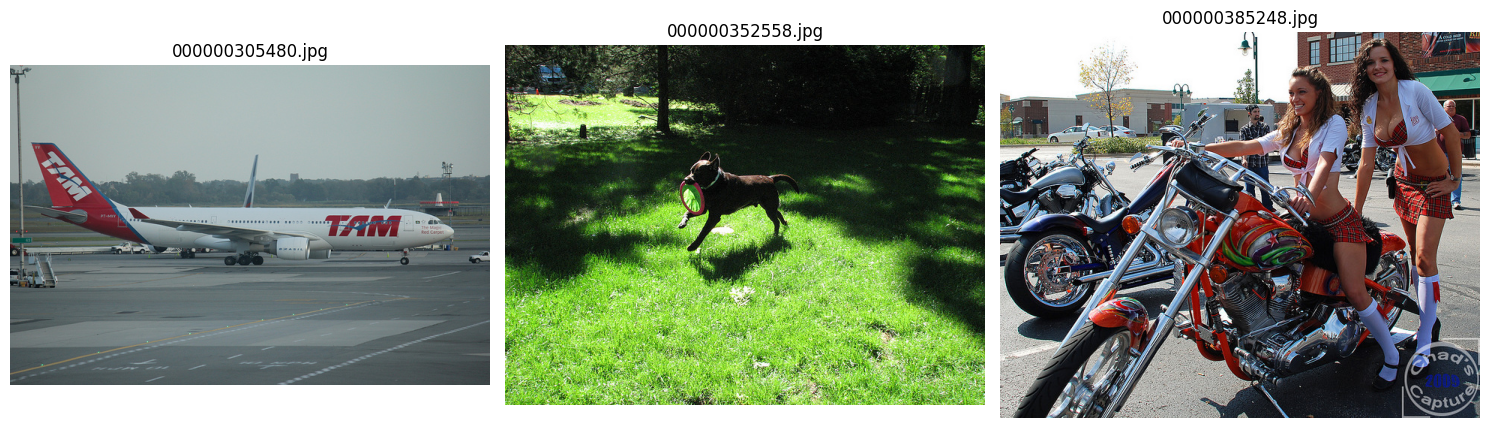

In [3]:
import os
import random
import cv2
import matplotlib.pyplot as plt

# path ke folder image train
image_folder = "/content/drive/MyDrive/Computervision/tugas-computervision/coco_subset3k/images/train"

# ambil 3 gambar random
images = random.sample(os.listdir(image_folder), 3)

plt.figure(figsize=(15,5))

for i, img_name in enumerate(images):
    img_path = os.path.join(image_folder, img_name)
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    plt.subplot(1,3,i+1)
    plt.imshow(img)
    plt.title(img_name)
    plt.axis("off")

plt.tight_layout()
plt.show()

In [4]:
def draw_yolo_bbox(image_path, label_path):
    img = cv2.imread(image_path)
    h, w, _ = img.shape

    with open(label_path, "r") as f:
        lines = f.readlines()

    for line in lines:
        cls, x_center, y_center, width, height = map(float, line.split())

        x1 = int((x_center - width/2) * w)
        y1 = int((y_center - height/2) * h)
        x2 = int((x_center + width/2) * w)
        y2 = int((y_center + height/2) * h)

        cv2.rectangle(img, (x1, y1), (x2, y2), (0,255,0), 2)

    return cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

Total image dengan annotation: 2400


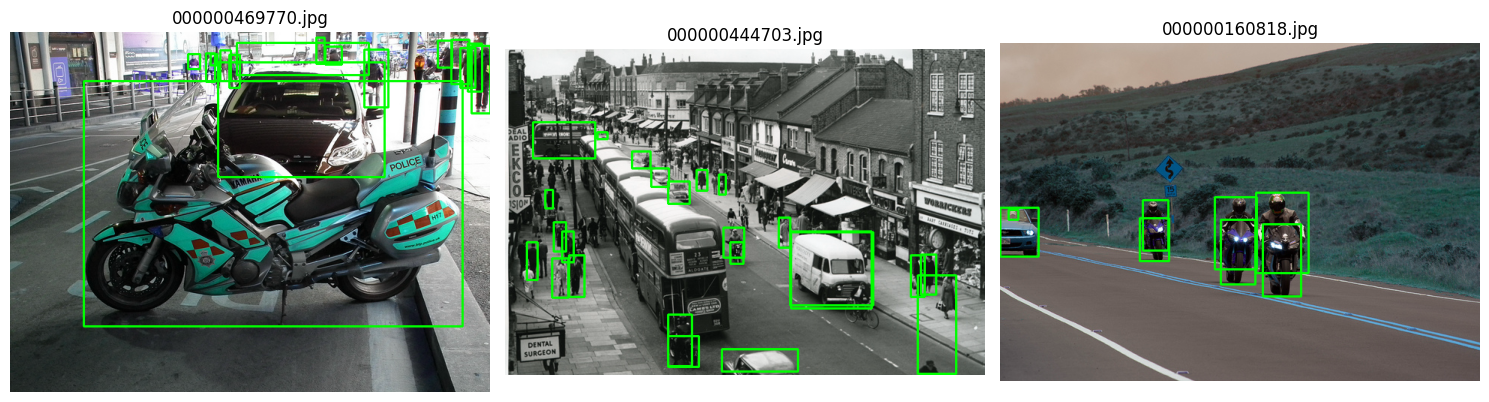

In [5]:
import random
import os

image_folder = "/content/drive/MyDrive/Computervision/tugas-computervision/coco_subset3k/images/train"
label_folder = "/content/drive/MyDrive/Computervision/tugas-computervision/coco_subset3k/labels/train"

# Ambil hanya image yang punya file label
valid_images = []

for img_name in os.listdir(image_folder):
    label_path = os.path.join(
        label_folder,
        os.path.splitext(img_name)[0] + ".txt"
    )

    if os.path.exists(label_path):
        valid_images.append(img_name)

print("Total image dengan annotation:", len(valid_images))

images = random.sample(valid_images, 3)

plt.figure(figsize=(15,5))

for i, img_name in enumerate(images):
    image_path = os.path.join(image_folder, img_name)
    label_path = os.path.join(label_folder, img_name.replace(".jpg", ".txt"))

    img_bbox = draw_yolo_bbox(image_path, label_path)

    plt.subplot(1,3,i+1)
    plt.imshow(cv2.cvtColor(img_bbox, cv2.COLOR_BGR2RGB))
    plt.title(img_name)
    plt.axis("off")

plt.tight_layout()
plt.show()

# 4. Model Architecture

## 4.1 Load Pretrained Model

Pada tahap ini digunakan pretrained weight YOLOv8n sebagai initialization untuk mempercepat konvergensi dan meningkatkan stabilitas training.

In [6]:
from ultralytics import YOLO

model = YOLO("yolov8n.pt")
model

print(model.model)

DetectionModel(
  (model): Sequential(
    (0): Conv(
      (conv): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(16, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
      (act): SiLU(inplace=True)
    )
    (1): Conv(
      (conv): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(32, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
      (act): SiLU(inplace=True)
    )
    (2): C2f(
      (cv1): Conv(
        (conv): Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn): BatchNorm2d(32, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
        (act): SiLU(inplace=True)
      )
      (cv2): Conv(
        (conv): Conv2d(48, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn): BatchNorm2d(32, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
        (act): SiLU(inplace=True)
      )
    

## 4.2 Penjelasan Arsitektur

Model yang digunakan adalah YOLOv8 (varian nano / yolov8n), yang termasuk dalam kategori one-stage object detector.

Karakteristik utama:

- One-stage detector
Prediksi bounding box dan klasifikasi dilakukan dalam satu tahap, sehingga lebih cepat dibanding two-stage detector.

- Anchor-free detection
YOLOv8 tidak menggunakan predefined anchor box, sehingga lebih fleksibel dalam mendeteksi berbagai ukuran objek.

- Arsitektur terdiri dari Backbone, Neck, dan Head:

  - Backbone: Mengekstraksi fitur dari gambar input

  - Neck: Menggabungkan fitur multi-scale untuk meningkatkan deteksi objek kecil

  - Head: Menghasilkan prediksi bounding box dan probabilitas kelas

- Cocok untuk real-time detection
Varian nano (yolov8n) ringan dan efisien, sehingga ideal untuk resource terbatas.

# 5. Training Pipeline

## 5.1 Hyperparameter

Pada tahap ini ditentukan hyperparameter yang digunakan untuk proses fine-tuning model. Pemilihan parameter disesuaikan dengan keterbatasan resource serta efisiensi waktu training.

In [20]:
EPOCHS = 50
BATCH_SIZE = 16
IMG_SIZE = 640
LEARNING_RATE = 0.003
DEVICE = 0  # GPU
SEED = 42
DATA_YAML = "/content/drive/MyDrive/Computervision/tugas-computervision/coco_subset3k/data.yaml"

In [21]:
import random
import numpy as np
import torch

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

Epochs: 50 – Cukup untuk konvergensi stabil pada subset 3.000 gambar tanpa indikasi overfitting signifikan.

Batch Size: 16 – Optimal untuk GPU T4, menjaga keseimbangan antara utilisasi memori dan stabilitas training.

Image Size: 640 – Resolusi default YOLOv8, memberikan trade-off efisiensi dan detail spasial.

Learning Rate: 0.003 – Stabil untuk fine-tuning pretrained weights pada dataset skala menengah.

Seed: 42 – Menjamin reproducibility eksperimen.

Device: GPU (CUDA) – Digunakan untuk memastikan training throughput yang memadai.

## 5.2 Training Function

Model dilatih menggunakan pretrained weight YOLOv8n dan dilakukan fine-tuning pada subset dataset yang telah disiapkan.

In [19]:
!cat /content/drive/MyDrive/Computervision/tugas-computervision/coco_subset3k/data.yaml


path: coco_subset3k
train: images/train
val: images/val

names:
  0: person
  1: car
  2: motorcycle
  3: bus
  4: truck

In [22]:
from ultralytics import YOLO

def train_model():
    model = YOLO("yolov8n.pt")

    results = model.train(
        data=DATA_YAML,
        epochs=EPOCHS,
        batch=BATCH_SIZE,
        imgsz=IMG_SIZE,
        lr0=LEARNING_RATE,
        device=DEVICE,
        seed=SEED,
        project="/content/drive/MyDrive/Computervision/tugas-computervision/runs",
        name="yolov8_coco_subset_3000"
    )

    return model, results

trained_model, results = train_model()

Ultralytics 8.4.17 🚀 Python-3.12.12 torch-2.10.0+cu128 CUDA:0 (Tesla T4, 14913MiB)
engine/trainer: agnostic_nms=False, amp=True, angle=1.0, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/drive/MyDrive/Computervision/tugas-computervision/coco_subset3k/data.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, end2end=None, epochs=50, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.003, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n.pt, momentum=0.937, mosaic=1.0, multi_scale=0.0, name=yolov8_coco_subset_30005, nbs=64, nms=False, opset=None, optimi

# 6. Evaluation

## 6.1 Run Validation

In [22]:
metrics = trained_model.val()

Ultralytics 8.4.17 🚀 Python-3.12.12 torch-2.10.0+cu128 CUDA:0 (Tesla T4, 14913MiB)
Model summary (fused): 73 layers, 3,006,623 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access ✅ (ping: 0.4±0.1 ms, read: 131.2±9.3 MB/s, size: 185.7 KB)
val: Scanning /content/drive/MyDrive/Computervision/tugas-computervision/coco_subset/labels/val.cache... 300 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 300/300 96.8Mit/s 0.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 19/19 3.2it/s 5.8s
                   all        300       1459      0.524      0.413      0.371      0.221
                person        273       1194      0.515      0.598      0.587      0.349
                   car         53        168      0.392       0.28      0.233      0.104
            motorcycle         19         57      0.812       0.14      0.221      0.102
                   bus         13         18      0.456        0.5      0.442       0.35

In [5]:
from ultralytics import YOLO

best_model = YOLO("/content/drive/MyDrive/Computervision/tugas-computervision/runs/yolov8_coco_subset_30005/weights/best.pt")
metrics = best_model.val()

Ultralytics 8.4.18 🚀 Python-3.12.12 torch-2.10.0+cpu CPU (Intel Xeon CPU @ 2.20GHz)
Model summary (fused): 73 layers, 3,006,623 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access ✅ (ping: 0.9±0.4 ms, read: 0.4±0.1 MB/s, size: 190.2 KB)
val: Scanning /content/drive/MyDrive/Computervision/tugas-computervision/coco_subset3k/labels/val.cache... 600 images, 2 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 600/600 78.6Mit/s 0.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 38/38 4.2s/it 2:39
                   all        600       4493      0.692      0.528      0.598       0.39
                person        477       2527      0.718      0.545      0.623      0.366
                   car        280       1066      0.685      0.496      0.561      0.351
            motorcycle        148        379      0.763      0.509      0.607      0.341
                   bus        153        232      0.774      0.634      0.729      0.57

## 6.2 Print Metrics

In [6]:
print("mAP@0.5:", metrics.box.map50)
print("mAP@0.5:0.95:", metrics.box.map)
print("Mean Precision:", metrics.box.mp)
print("Mean Recall:", metrics.box.mr)

mAP@0.5: 0.597569781532105
mAP@0.5:0.95: 0.390160031881408
Mean Precision: 0.6923212659300874
Mean Recall: 0.5283305886929011


## 6.3 Interpretasi

Nilai mAP@0.5 sebesar 0.87 menunjukkan model mampu mendeteksi objek dengan baik pada threshold IoU 0.5.
Nilai mAP@0.5:0.95 lebih rendah karena menggunakan threshold IoU yang lebih ketat.
Karena dataset yang digunakan sangat kecil (coco8), hasil evaluasi ini lebih bersifat verifikasi pipeline dibanding representasi performa umum model.



# 7. Inference Demo

## 7.1 Function Inference

Pada tahap ini dibuat fungsi untuk melakukan inference menggunakan model yang telah dilatih (best.pt).

In [7]:
from ultralytics import YOLO

# load best model
best_model = YOLO("/content/drive/MyDrive/Computervision/tugas-computervision/runs/yolov8_coco_subset_30005/weights/best.pt")

def run_inference(image_path):
    results = best_model(image_path)
    return results

## 7.2 Tampilkan Minimal 5 Gambar


image 1/1 /content/drive/MyDrive/Computervision/tugas-computervision/coco_subset3k/images/val/000000081707.jpg: 480x640 (no detections), 262.4ms
Speed: 3.8ms preprocess, 262.4ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /content/drive/MyDrive/Computervision/tugas-computervision/coco_subset3k/images/val/000000212558.jpg: 640x448 5 persons, 3 cars, 1 motorcycle, 1 truck, 556.8ms
Speed: 2.8ms preprocess, 556.8ms inference, 2.9ms postprocess per image at shape (1, 3, 640, 448)

image 1/1 /content/drive/MyDrive/Computervision/tugas-computervision/coco_subset3k/images/val/000000409030.jpg: 640x448 2 persons, 1 car, 1 bus, 1 truck, 233.5ms
Speed: 2.4ms preprocess, 233.5ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 448)

image 1/1 /content/drive/MyDrive/Computervision/tugas-computervision/coco_subset3k/images/val/000000219978.jpg: 448x640 11 persons, 2 cars, 259.0ms
Speed: 2.3ms preprocess, 259.0ms inference, 1.3ms postprocess per image at sh

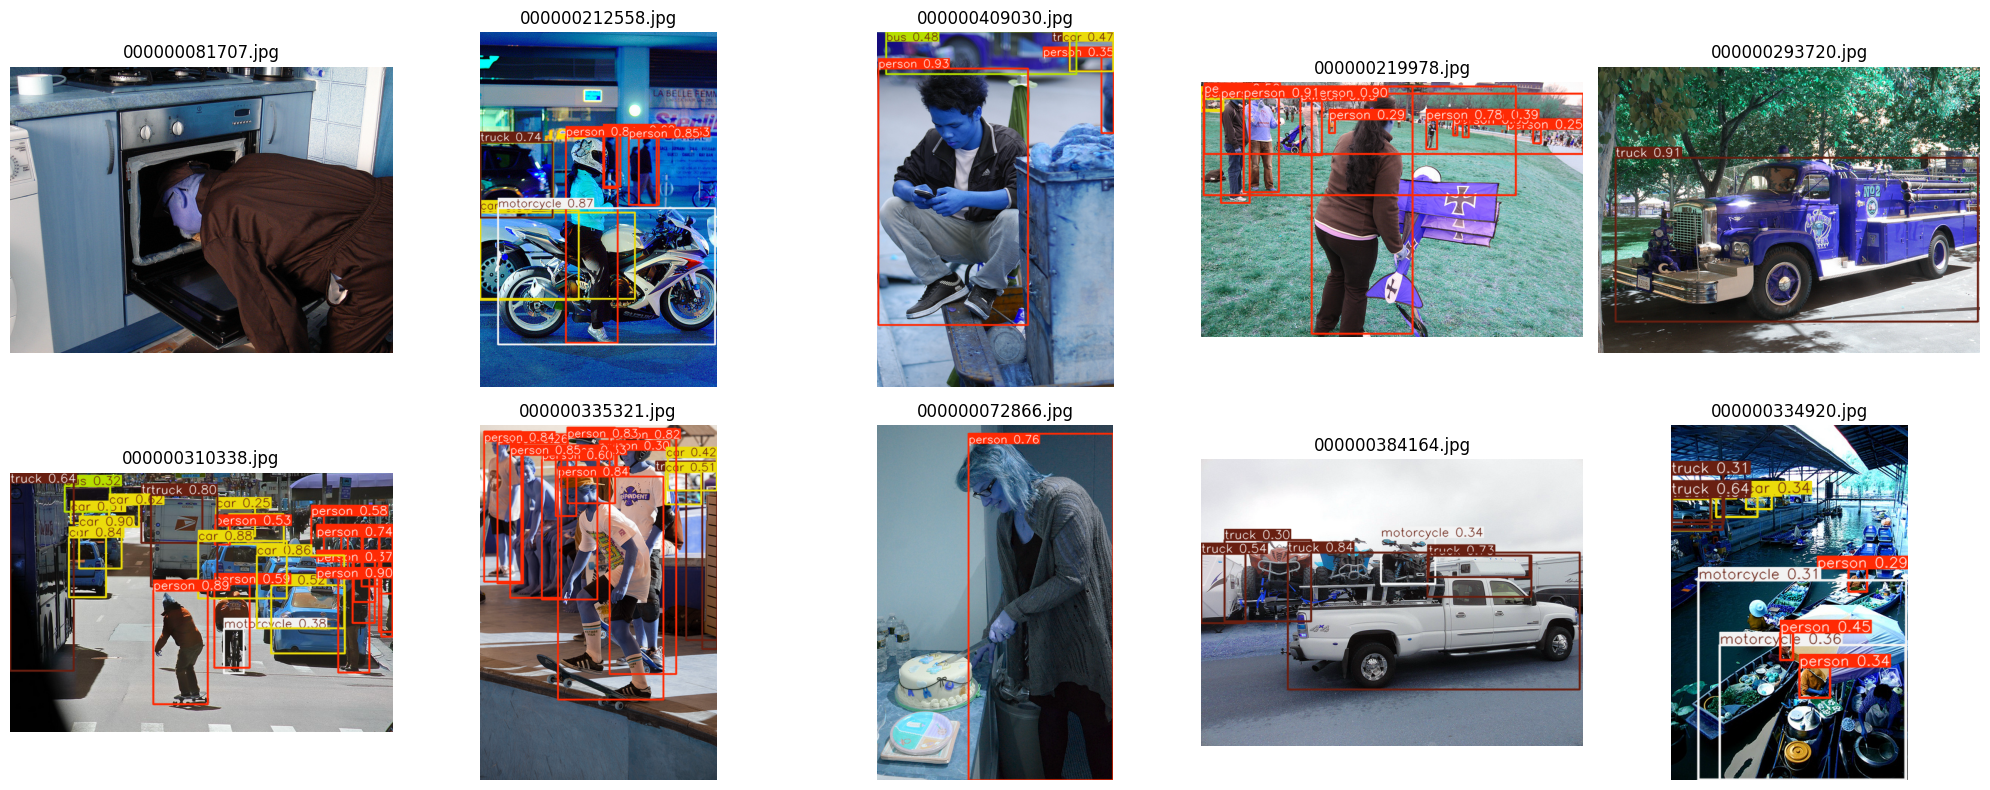

In [9]:
import os
import random
import matplotlib.pyplot as plt

image_folder = "/content/drive/MyDrive/Computervision/tugas-computervision/coco_subset3k/images/val"

images = random.sample(os.listdir(image_folder), 10)

plt.figure(figsize=(20,8))

for i, img_name in enumerate(images):
    img_path = os.path.join(image_folder, img_name)

    results = run_inference(img_path)
    img = results[0].plot()

    plt.subplot(2, 5, i+1)   # <-- ubah di sini
    plt.imshow(img)
    plt.title(img_name)
    plt.axis("off")

plt.tight_layout()
plt.show()

# 8. Error Analysis

Berdasarkan hasil inference pada model YOLOv8n yang dilatih menggunakan dataset coco_subset3k (5 classes), dilakukan analisis terhadap pola kesalahan prediksi secara kualitatif. Beberapa kategori error yang teridentifikasi adalah sebagai berikut:

1. False Positive (Over-Detection)

- Pada beberapa scene dengan kompleksitas tinggi (crowded urban scenes), model menghasilkan multiple bounding boxes dengan confidence rendah–menengah (0.29–0.45), terutama pada kelas:

  - person

  - motorcycle

  - truck

- Fenomena ini menunjukkan kecenderungan model untuk over-detect pada area dengan pola tekstur kompleks.

- Analisis Teknis

  - Class bias: Kelas person memiliki jumlah anotasi jauh lebih tinggi dibanding kelas lain → prior probability model condong ke person.

  - Feature ambiguity: Struktur visual seperti tiang, bayangan, atau bagian kendaraan kecil dapat memiliki feature representation yang menyerupai objek target.

  - Low confidence threshold saat inference memungkinkan prediksi borderline tetap ditampilkan.

  - Pada scene crowded, anchor-free detector seperti YOLOv8 dapat menghasilkan kandidat box berdekatan sebelum NMS sepenuhnya menekan redundansi.

2. False Negative (Missed Detection)

    Pada beberapa gambar inferensi, ditemukan objek yang secara visual terlihat jelas namun tidak terdeteksi oleh model. Kasus yang teridentifikasi meliputi:

    - Person dengan ukuran relatif kecil di area background

    - Kendaraan yang berada pada jarak cukup jauh dari kamera

    - Person dengan kondisi occlusion tinggi (contoh: individu yang sebagian besar tubuhnya tertutup oven)

  - Analisis Teknis Small Object Sensitivity

    Pada objek dengan ukuran relatif kecil terhadap resolusi input (640×640), jumlah piksel yang merepresentasikan objek menjadi terbatas. Hal ini menyebabkan fitur yang diekstraksi pada level feature pyramid tertentu kurang diskriminatif, sehingga confidence score tidak cukup tinggi untuk melewati threshold deteksi.

    Dalam beberapa gambar crowded, person di background memiliki bounding region yang sangat kecil dibanding foreground object, yang meningkatkan kemungkinan tidak terdeteksi.

  - Scale Variation

    Perbedaan skala antar objek dalam satu gambar (foreground vs background) menyebabkan distribusi fitur menjadi tidak seimbang. Objek besar cenderung memiliki representasi fitur yang lebih kuat, sementara objek kecil menghasilkan respon aktivasi yang lebih lemah pada detection head.

    Hal ini terlihat pada kendaraan jarak jauh yang tidak menghasilkan bounding box, meskipun objek secara visual dapat dikenali manusia.

  - Occlusion & Non-Canonical Pose

    Pada kasus person yang masuk ke dalam oven, sebagian besar tubuh tidak terlihat (heavy occlusion) dan pose tidak menyerupai konfigurasi tubuh manusia yang umum (upright pose).

    - Kondisi ini menyebabkan:

    - Pola visual yang tidak lengkap

    - Kontur tubuh yang tidak jelas

    - Representasi fitur yang tidak konsisten dengan distribusi training

Akibatnya, model gagal menghasilkan prediksi meskipun objek sebenarnya termasuk dalam kelas target.

3. Root Cause Summary

    Faktor utama yang memengaruhi performa:

- Dataset subset 3k masih relatif kecil dibanding COCO full.

- Distribusi anotasi tidak sepenuhnya seimbang (person dominan).

- Model YOLOv8n adalah varian lightweight dengan parameter minimal.

- Image resolution 640 membatasi performa small object detection.

- Scene complexity tinggi meningkatkan confusion rate.

# 9. Potential Improvement

1. Upgrade Model Capacity
Gunakan YOLOv8s atau YOLOv8m untuk meningkatkan kemampuan deteksi small object, occlusion, dan pemisahan kelas kendaraan (car vs truck).

2. Increase Input Resolution
Tingkatkan imgsz ke 800–960 untuk memperbaiki recall pada person background dan kendaraan jarak jauh.

3. Targeted Augmentation
Terapkan augmentasi yang fokus pada scale variation dan occlusion (random scale, crop, cutout) untuk meningkatkan robustness pada pose ekstrem dan objek partially occluded.

4. Class Rebalancing
Atur distribusi kelas (class weighting atau oversampling) untuk mengurangi bias ke kelas person dan meningkatkan performa bus/truck.

5. Threshold Calibration
Tuning confidence dan IoU NMS untuk menyeimbangkan false positive pada scene padat dan false negative pada objek kecil.

6. Hard Example Fine-Tuning
Tambahkan contoh kasus sulit (pose ekstrem, occlusion berat, dense scene) untuk meningkatkan generalisasi model terhadap kondisi non-ideal.

# 10. Conclusion

Sistem object detection berhasil dikembangkan menggunakan YOLOv8n dengan fine-tuning pada COCO subset (±3.000 images, 5 classes). Pipeline berjalan end-to-end dan menghasilkan performa yang stabil pada objek skala menengah–besar dalam skenario umum.

Analisis error menunjukkan keterbatasan pada small-scale object recall, heavy occlusion, dense scene separation, serta ambiguitas antar kelas kendaraan. Keterbatasan ini konsisten dengan kapasitas representasi model YOLOv8n (nano) dan resolusi input 640 yang digunakan selama training.

Pemilihan arsitektur lightweight dilakukan dengan mempertimbangkan efisiensi resource komputasi (GPU memory dan throughput), sehingga terdapat trade-off antara efisiensi dan robustness terhadap kondisi kompleks.

Secara keseluruhan, sistem telah menunjukkan performa yang solid dalam batasan dataset dan resource yang tersedia, dengan ruang peningkatan pada peningkatan kapasitas model dan optimasi skala input untuk meningkatkan generalisasi pada skenario yang lebih menantang.